In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# 数据集和数据加载器



用于处理数据样本的代码可能会变得混乱且难以维护；理想情况下，我们希望数据集代码与模型训练代码分离，以获得更好的可读性和模块化性。
PyTorch 提供了两个数据原语：torch.utils.data.DataLoader和torch.utils.data.Dataset 允许您使用预加载的数据集以及您自己的数据。
Dataset存储样本及其相应的标签，DataLoader对Dataset进行迭代以方便访问样本。

PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST），它们子类化torch.utils.data.Dataset并实现特定于特定数据的函数。
它们可用于对您的模型进行原型设计和基准测试。
您可以在这里找到它们：图像数据集、 文本数据集和 音频数据集
[Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)




## 加载数据集

Fashion-MNIST 是 Zalando 文章图像的数据集，由 60,000 个训练示例和 10,000 个测试示例组成。每个示例包含一个 28×28 灰度图像和来自 10 个类别之一的关联标签。

我们使用以下参数加载FashionMNIST 数据集：
- root是存储训练/测试数据的路径，
- train指定训练或测试数据集，
- download=True如果 上没有数据，则从 Internet 下载数据root。
- transform并target_transform指定特征和标签转换

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 迭代和可视化数据集

我们可以Datasets像列表一样手动索引：
training_data[index]。我们用来matplotlib可视化训练数据中的一些样本。

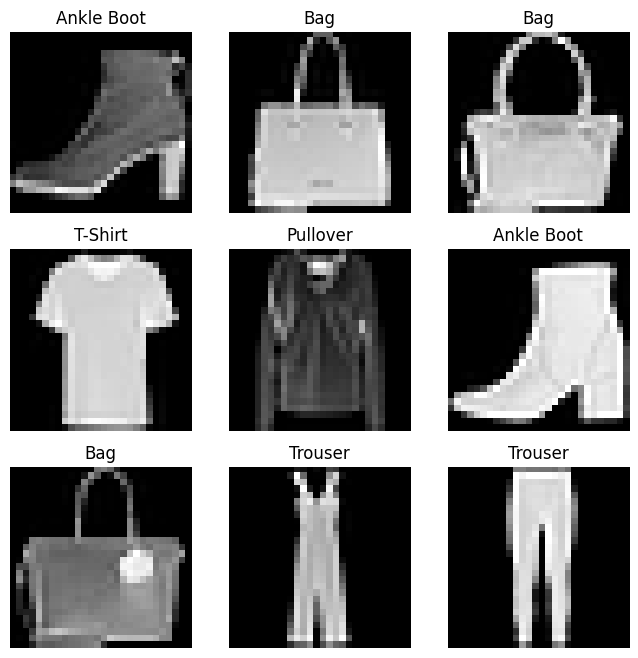

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 为您的文件创建自定义数据集


自定义 Dataset 类必须实现三个函数：__init__、__len__和__getitem__。
FashionMNIST 图像存储在一个目录中img_dir，它们的标签单独存储在一个 CSV 文件中annotations_file

In [5]:
import os
import pandas as pd
from torchvision.io import read_image


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)  #标签单独存储在一个 CSV 文件中annotations_file
        self.img_dir = img_dir  #图像存储在一个目录中img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __init__

__init__ 函数在实例化 Dataset 对象时运行一次。
我们初始化包含图像、注释文件和两种转换的目录（下一节将更详细地介绍）。



In [6]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

__len__ 函数返回数据集中的样本数。



In [7]:
def __len__(self):
    return len(self.img_labels)

### __getitem__

__getitem__ 函数加载并返回给定索引处的数据集的样本idx。
基于索引，它识别图像在磁盘上的位置，使用 将其转换为张量read_image，从 中的 csv 数据中检索相应的标签self.img_labels，
调用它们的转换函数（如果适用），并返回张量图像和相应的标签一个元组。


In [8]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




## 使用 DataLoaders 准备数据以进行训练

它Dataset检索我们的数据集的特征并一次标记一个样本。
在训练模型时，我们通常希望以“小批量”方式传递样本，在每个时期重新整理数据以减少模型过度拟合，并使用 Python 来加速multiprocessing数据检索。
DataLoader是一个可迭代对象，它通过一个简单的 API 为我们抽象了这种复杂性。

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 遍历 DataLoader

我们已将该数据集加载到 中DataLoader，并且可以根据需要迭代数据集。
下面的每次迭代都会返回一批train_features和train_labels（batch_size=64分别包含特征和标签）。
因为我们指定了shuffle=True，所以在迭代所有批次后，数据将被打乱（为了更细粒度地控制数据加载顺序，请查看Samplers）。


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


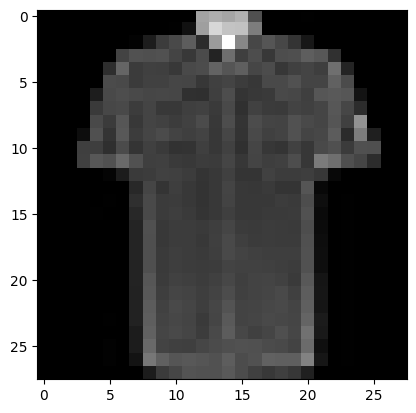

Label: 6


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

--------------




## 进一步阅读
- [torch.utils.data API](https://pytorch.org/docs/stable/data.html)
